In [5]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import batch_run

import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt

In [6]:
class MoneyAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.wealth = 1

    def move(self):
        possible_cells = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False
        )
        new_position = self.random.choice(possible_cells)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

In [7]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

In [8]:
class MoneyModel(Model):
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        

In [9]:
NUM_AGENTS = 50
WIDTH = 10
HEIGHT = 10
STEPS = 100

model = MoneyModel(NUM_AGENTS, WIDTH, HEIGHT)
for i in range(STEPS):
    model.step()

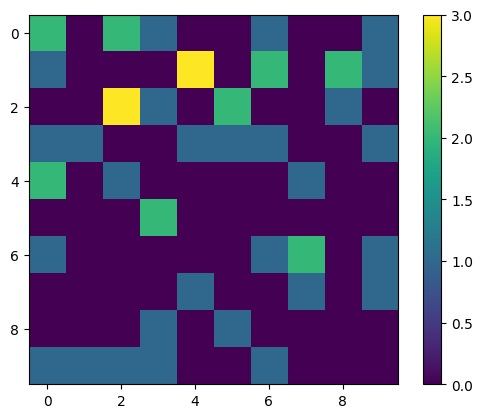

In [10]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    (cell_content, (x, y)) = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
    
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

<Axes: >

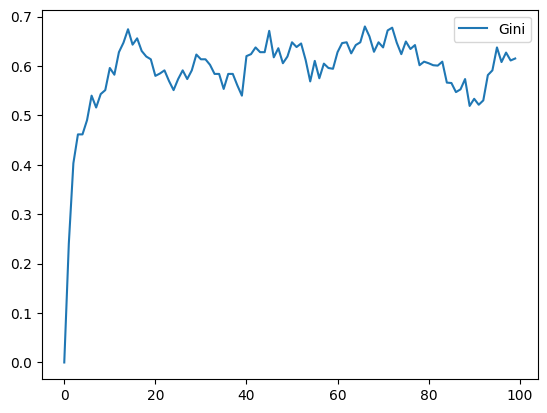

In [11]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

(array([25.,  0., 10.,  0.,  0.,  7.,  0.,  6.,  0.,  2.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

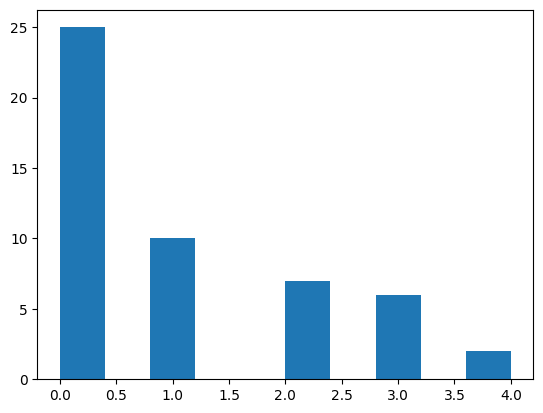

In [12]:
agent_wealth = [agent.wealth for agent in model.schedule.agents]
plt.hist(agent_wealth)

(array([236., 560., 176.,  28.]),
 array([0., 1., 2., 3., 4.]),
 <BarContainer object of 4 artists>)

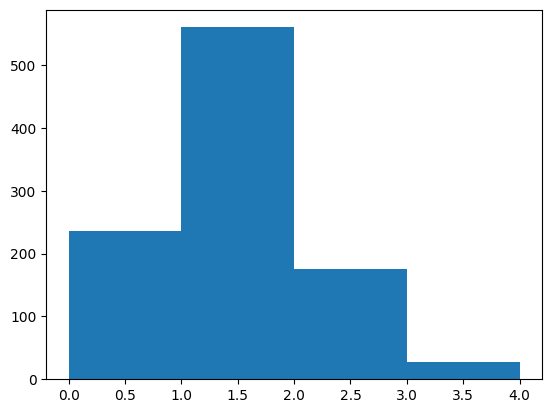

In [13]:
all_wealth = []
for j in range(100):
    model = MoneyModel(10, 10, 10)
    for i in range(10):
        model.step()
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

plt.hist(all_wealth, bins=range(max(all_wealth) + 1))

In [14]:
params = {"width" : 10, "height" : 10, "num_agents": range(10, 500, 10)}
simulation_result = batch_run(MoneyModel, params, iterations=5, max_steps=100)

  0%|          | 0/245 [00:00<?, ?it/s]

TypeError: MoneyModel.__init__() got an unexpected keyword argument 'num_agents'